In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.signal import argrelmin
from scipy.special import wofz
from scipy import constants as consts

plt.rcParams['axes.labelsize'] = 25
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize']=25
plt.rcParams['ytick.labelsize']=25
plt.rcParams['lines.linewidth'] = 3

%matplotlib inline

# Teil 2

**Vorarbeit**

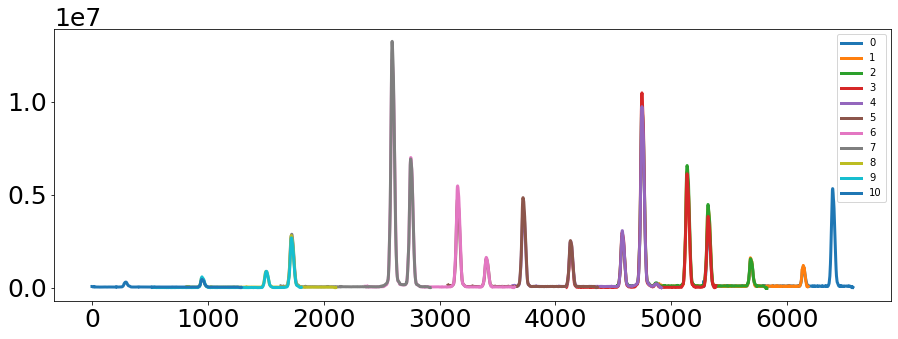

In [10]:
%matplotlib inline

neon = [[] for _ in range(11)]
for i in range(11):
    neon[i] = np.loadtxt(f"data\\Neon\\Neon_values_{i+1}.txt",skiprows=1, usecols=(0,1), unpack=True, max_rows=1290)
    Imin = np.min(neon[i][1])
    neon[i][1] -= Imin #setting to zero
neon = np.array(neon)   

shift_x = [5279, 4893, 4537, 4096, 3626, 3074, 2358, 1630, 815, 518,0]
scaling = [1,0.8,2.8,2.5,2.25,2.0,1.8,1.65,1.2,1.2,1]
shift_y = [0,0.04e6,-0.04e6,0,0,0,0,0,0,0,0]
for i in range(11):
    neon[i][0] += shift_x[i]
    neon[i][1] *= scaling[i]
    neon[i][1] += shift_y[i]
    
fig, ax = plt.subplots(figsize=(15,5))
for i, data in enumerate(neon):
    ax.plot(data[0], data[1], label = f"{i}")
ax.legend()

In [3]:
neon_total = np.concatenate((neon[10][1][0:1200], 
                             neon[9][1][682:1200], 
                             neon[7][1][88:1250],
                             neon[6][1][522:1250],
                             neon[5][1][534:1250],
                             neon[3][1][228:1150],
                             neon[2][1][709:900],
                             neon[0][1][158:]
                            ))
pixels_total = np.concatenate((neon[10][0][0:1200], 
                               neon[9][0][682:1200],
                               neon[7][0][88:1250],
                               neon[6][0][522:1250],
                               neon[5][0][534:1250],
                               neon[3][0][228:1150],
                               neon[2][0][709:900],
                               neon[0][0][158:]
                              ))


In [4]:
peaks, _ = find_peaks(neon_total, height=2.96e5)
peaks = np.delete(peaks, [1,2,4,5,18,20,21])
peaks

array([ 288,  953, 1504, 1724, 2591, 2751, 3156, 3403, 3721, 4130, 4576,
       4747, 5137, 5317, 5694, 6141, 6393], dtype=int64)

## Plot des gesamten Spektrums

In [5]:
pic10 = plt.imread(f"data\\Neon\\11.jpg")[:,0:1200,:]
pic9 = plt.imread(f"data\\Neon\\10.jpg")[:,682:1200,:]
pic7 = plt.imread(f"data\\Neon\\8.jpg")[:,88:1250,:]
pic6 = plt.imread(f"data\\Neon\\7.jpg")[:,522:1250,:]
pic5 = plt.imread(f"data\\Neon\\6.jpg")[:,534:1250,:]
pic3 = plt.imread(f"data\\Neon\\4.jpg")[:,228:1150,:]
pic2 = plt.imread(f"data\\Neon\\3.jpg")[:,709:900,:]
pic0 = plt.imread(f"data\\Neon\\1.jpg")[:,158:,:]

pic = np.concatenate((pic10,pic9,pic7,pic6,pic5,pic3,pic2,pic0), axis=1)
np.shape(pic)

(1024, 6559, 3)

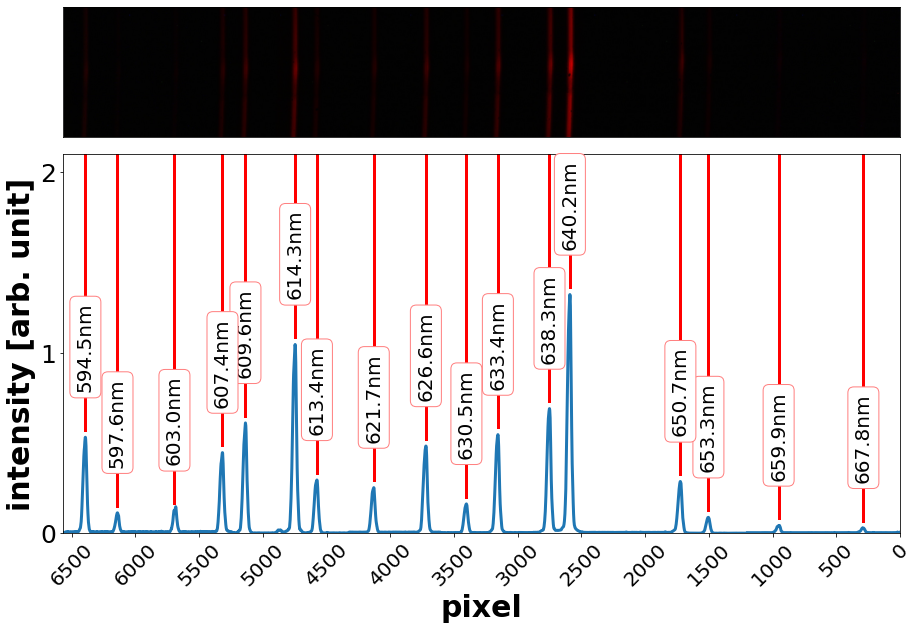

In [6]:
fig, ax = plt.subplots(2,1,figsize=(15,10), 
                       gridspec_kw = {'wspace':0, 'hspace':0, 
                                      'height_ratios': [1, 2.3]})
ax[1].set_xlim(np.max(pixels_total), np.min(pixels_total))
ax[1].plot(pixels_total, neon_total)
ax[1].set_xticks(range(0,int(np.max(pixels_total)),500))
ax[1].set_xticklabels(range(0,int(np.max(pixels_total)),500), rotation=45,size=20)
ax[1].set_ylim(0,2.1e7)
ax[1].set_yticks([0,1e7,2e7])
ax[1].set_yticklabels([0,1,2], size=25)
peak_length = [667.8,659.9,653.3,650.7,640.2,638.3,633.4,630.5,626.6,621.7,613.4,614.3,609.6,607.4,603.0,597.6,594.5]
for peak,l in zip(peaks,peak_length):
    ax[1].plot([peak, peak],[neon_total[peak]+0.04e7,2.1e7], color = 'red')
    ax[1].text(peak, neon_total[peak]+0.5e7, f"{l}nm", size=20, rotation = 90,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 1., 1.),
                   )
         )
    
ax[1].set_xlabel("pixel",size=30)
ax[1].set_ylabel("intensity [arb. unit]",size=30)

ax[0].set_xlim(np.max(pixels_total), np.min(pixels_total))
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].imshow(pic)

fig.savefig("plots/NeonSpectrum.png")
plt.show()

## Bestimmung der Wellenlänge

In [7]:
data = np.loadtxt(f"data\\Cd_wavelength\\cd_neon.txt",skiprows=1, usecols=(0,1), unpack=True, max_rows=1299)
data[1] -=np.min(data[1])
data[1] /=np.max(data[1])

px = data[0]
I = data[1]

In [8]:
# fit gauss/Voigt to the peaks
def gauss(x,a,mu,sig,c):
    return a*np.exp(-((x-mu)*(x-mu))/(sig*sig))+c

def V(x, a, x0, sigma, gamma, off, oc):
    return a * np.real(wofz(((x-x0) + 1j*gamma)/sigma/np.sqrt(2))) +off + oc*x

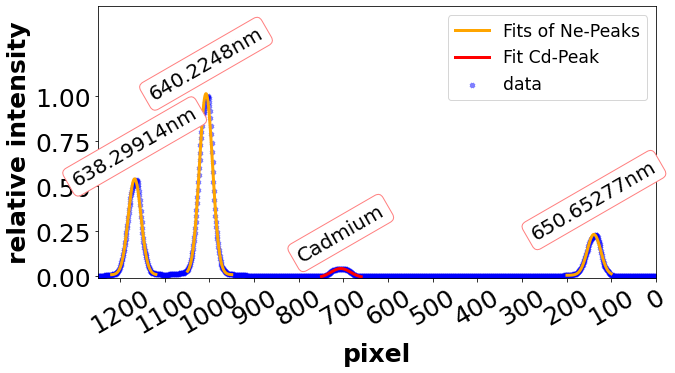

In [9]:
#Peak Bereiche für Fit
px2, I2 = px[950:1050], I[950:1050]
px1, I1 = px[100:200], I[100:200]
px3, I3 = px[1120:1220], I[1120:1220]
pxCd, ICd = px[660:750], I[660:750]

#Fit
p1, cov1 = curve_fit(gauss, px1, I1, p0=[2,150,10,0]) 
p2, cov2 = curve_fit(gauss, px2, I2, p0=[1,1000,40,0])
p3, cov3 = curve_fit(gauss, px3, I3, p0=[0.0001,1167,10,0])
pCd, covCd = curve_fit(gauss, pxCd, ICd, p0=[1,700,20,0])

plt.figure(figsize=(10,5))
plt.xlim(1250,0)
plt.xticks(range(0,1250,100), rotation = 30) #Umkehren der Achsen

plt.scatter(px, I,marker = 'x', color = 'blue', s=15, label = "data", alpha=0.5)


plt.plot(px1, gauss(px1,*p1), color = "orange", zorder = 1, label = "Fits of Ne-Peaks")
plt.plot(px2, gauss(px2,*p2), color = "orange", zorder = 1)
plt.plot(px3, gauss(px3,*p3), color = "orange", zorder = 1)

plt.plot(pxCd, gauss(pxCd,*pCd), color = "red", zorder = 1, label = "Fit Cd-Peak")

plt.xlabel("pixel")
plt.ylabel("relative intensity")
plt.legend(fontsize="xx-large")
plt.ylim(-0.01,1.5)
plt.yticks([0, 0.25, 0.5, 0.75,1]) #Umkehren der Achsen

means = np.array([p1[1], p2[1], p3[1], pCd[1]])
stds = np.array([cov1[1,1]**0.5,cov2[1,1]**0.5,cov3[1,1]**0.5,covCd[1,1]**0.5])
lam = ["650.65277nm", "640.2248nm", "638.29914nm","Cadmium"]
for m,l in zip(means,lam):
    plt.text(m, I[int(m)]+0.2, l, size=20, rotation = 30,
         ha="center", va="center", zorder = 10,
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 1., 1.),
                   )
         )
    
plt.savefig("plots/NeCdPeaks.png")

**Linearer Fit mit Ne-Spektrum als Referenz**

λ_Cd = 643.845 (+ 0.01 - 0.01)


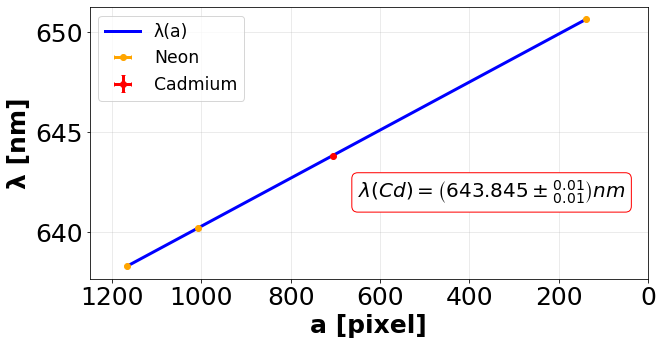

In [10]:
neon_lambda = [650.65277, 640.2248, 638.29914]

plt.figure(figsize=(10,5))
plt.xlim(1250,0)
plt.errorbar(x=means[:-1],y=neon_lambda, xerr = stds[:-1], fmt='o', color = "orange", label = "Neon", capsize=2)

def line(x,m,c):
    return x*m+c

pline, covline = curve_fit(line, means[:-1], neon_lambda)
m, merr = pline[0] ,covline[0,0]**0.5
c, cerr = pline[1] ,covline[1,1]**0.5
plt.plot(means[:-1], line(means[:-1],*pline), color = "blue", label ="λ(a)")

λ_Cd = float(line(means[-1],*pline))
λ_Cd_max = float(line(means[-1],m+merr,c+cerr))
λ_Cd_min = float(line(means[-1],m-merr,c-cerr))

λplus = λ_Cd_max-λ_Cd
λminus = λ_Cd-λ_Cd_min

λ_Cd = np.round(λ_Cd, 3)
λplus = np.round(λplus,3)
λminus = np.round(λminus,3)
print(f"λ_Cd = {λ_Cd} (+ {λplus} - {λminus})")
plt.errorbar(means[-1], line(means[-1],*pline), xerr = stds[-1], yerr = λplus,
             fmt='o',color = 'red', label="Cadmium", capsize = 2)
plt.legend(fontsize="xx-large")
plt.text(350, 642, "$λ(Cd) = $" + f"$\\left({λ_Cd}\pm^{{0.01}}_{{0.01}}\\right)nm$", size=20,
         ha="center", va="center", zorder = 10,
         bbox=dict(boxstyle="round",
                   ec="red",
                   fc=(1., 1., 1.),
                   )
         )

plt.xlabel("a [pixel]")
plt.ylabel("λ [nm]")
plt.grid(alpha=0.3)
plt.savefig("plots/CadmiumWavelengthFit.png")
plt.show()

**Literaturwert: 643.84695** (https://physics.nist.gov/cgi-bin/ASD/lines1.pl?spectra=Cd&limits_type=0&low_w=640&upp_w=650&unit=1&submit=Retrieve+Data&de=0&lte_out=2&format=0&line_out=0&en_unit=0&output=0&bibrefs=1&page_size=15&show_obs_wl=1&show_calc_wl=1&unc_out=1&order_out=0&max_low_enrg=&show_av=2&max_upp_enrg=&tsb_value=0&min_str=&A_out=0&intens_out=on&max_str=&allowed_out=1&forbid_out=1&min_accur=&min_intens=&conf_out=on&term_out=on&enrg_out=on&J_out=on)

liegt im 1 sigma Bereich

Relativer Fehler: 0.0015%

=> sehr gutes Ergebnis

# Part 1

In [11]:
I=np.array([1,2,3,4,5,6,7,8,9,10,11,12,13]) #Amperes

B1up=np.array([.056,.109,.162,.213,.268,.318,.370,.421,.460,.512,.547,.578,.603]).reshape(1,13) # Teslas
B2up=np.array([.057,.108,.163,.213,.266,.315,.366,.416,.464,.513,.546,.577,.602]).reshape(1,13)
B3up=np.array([.056,.107,.162,.213,.266,.320,.371,.418,.462,.506,.550,.573,.607]).reshape(1,13)

B1down=np.array([np.nan,.584,.553,.515,.467,.417,.371,.319,.267,.214,.162,.110,.057])[::-1].reshape(1,13)
B2down=np.array([np.nan,.582,.551,.511,.466,.419,.373,.317,.265,.213,.161,.112,.058])[::-1].reshape(1,13)
B3down=np.array([np.nan,.577,.548,.510,.467,.416,.368,.316,.266,.214,.162,.109,.057])[::-1].reshape(1,13)


Ierr =np.ones(len(I))*0.25


Bup = np.mean(np.concatenate((B1up, B2up, B3up)).T, axis=1)
Bup_err = np.std(np.concatenate((B1up, B2up, B3up)).T, axis=1, ddof=1)

Bdown = np.mean(np.concatenate((B1down, B2down, B3down)).T, axis=1)
Bdown_err = np.std(np.concatenate((B1down, B2down, B3down)).T, axis=1, ddof=1)

B = np.nanmean(np.concatenate((B1up, B2up, B3up, B1down, B2down, B3down)).T, axis=1)
B_err = np.nanstd(np.concatenate((B1up, B2up, B3up, B1down, B2down, B3down)).T, axis=1, ddof=1)

Da man sehen kann, dass sich die Werte kaum unterscheiden wird über alle gemittelt und dann gefittet

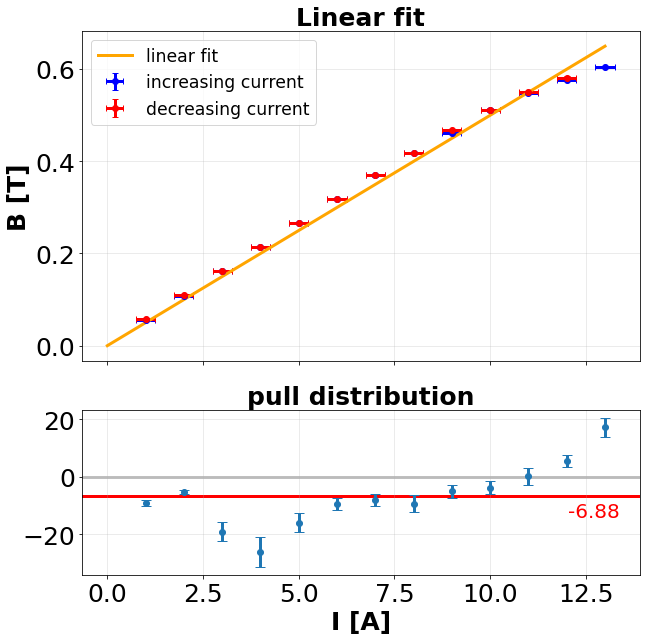

In [30]:
def funcB(I,a):
    return I*a

fig, axs = plt.subplots(2,1, figsize=(10,10), sharex=True,
                       gridspec_kw = {'wspace':0.2, 'hspace':0.2, 
                                      'height_ratios': [2, 1]})
axs[0].set_title('Linear fit')
axs[0].set_ylabel("B [T]")
axs[0].errorbar(I,Bup, xerr=Ierr, yerr=Bup_err, fmt='o', capsize=3, color = 'blue', label = 'increasing current')
axs[0].errorbar(I,Bdown, xerr=Ierr, yerr=Bdown_err, fmt='o', capsize=3, color = 'red', label = 'decreasing current')

p, cov = curve_fit(funcB, I, B)
Bline = np.linspace(0,13,100)
axs[0].plot(Bline, funcB(Bline,*p), color = 'orange', label = 'linear fit')
axs[0].grid(alpha=0.3)
axs[0].legend(fontsize="xx-large")


a = p[0]
a_err = np.sqrt(cov[0][0])

B_fit = a*I
B_fit_err = a_err*I

pull = (B_fit-B)/B_err
pull_err = np.sqrt((B_fit_err/B_err)**2)

axs[1].set_title('pull distribution')
axs[1].errorbar(I, pull,yerr=pull_err, fmt='o', capsize = 5)
axs[1].axhline(0, color = 'gray',zorder=-1, alpha=0.5)
axs[1].axhline(np.mean(pull), color='red',zorder=-1)
axs[1].set_xlabel("I [A]")
#axs[1].ylabel("$\sigma_{pull}$")
axs[1].grid(alpha=0.3)

axs[1].text(12.7, np.mean(pull)-2, f"{np.round(np.mean(pull),2)}", size=20,
         ha="center", va="top", zorder = 10, color='red')


fig.savefig("plots/magneticfield.png")

Etwas in die Richtung:
*We also notice saturation effects. In an ideal electromagnet
we would have B / I. However, since our
magnet mainly consists of iron, which itself is ferromagnetic,
it looses its ability to provide more magnetic field
strength B(I) at high currents as most of the elementary
magnets are already aligned resulting in a saturation
curve. Therefore, fitting the measured values with
a straight line through the origin (B(I) = aI) is not sufficient. 
We will therefore use the actual values of the B
field instead of the linearised values for B(I).*

=> Das der Fit nicht gut ist sieht man auch in den residuals:

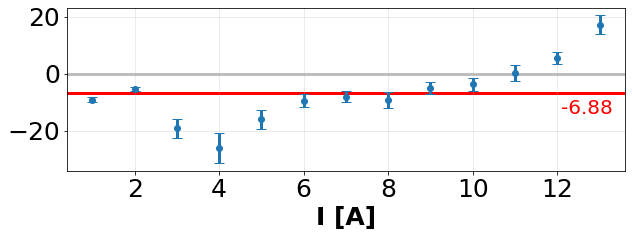

In [22]:
a = p[0]
a_err = np.sqrt(cov[0][0])

B_fit = a*I
B_fit_err = a_err*I

pull = (B_fit-B)/B_err
pull_err = np.sqrt((B_fit_err/B_err)**2)

plt.errorbar(I, pull,yerr=pull_err, fmt='o', capsize = 5)
plt.axhline(0, color = 'gray',zorder=-1, alpha=0.5)
plt.axhline(np.mean(pull), color='red',zorder=-1)
plt.xlabel("I [A]")
#plt.ylabel("$\sigma_{pull}$")
plt.grid(alpha=0.3)

plt.text(12.7, np.mean(pull)-2, f"{np.round(np.mean(pull),2)}", size=20,
         ha="center", va="top", zorder = 10, color='red')

plt.savefig("plots/pulldistributionB.png")

Man sieht systematischen Verlauf 

und $\bar{\sigma}$ muss im Bereich $\pm 3$ liegen!

In [23]:
#wir brauchen nur die Magnetfelder ab I=8A
B1 = B[7:]
B1_err = B_err[7:]
print(I[7:])

[ 8  9 10 11 12 13]


In [24]:
#daten lesen
data1 = [[] for _ in range(6)]
for i in range(6):
    data1[i] = np.loadtxt(f"data\\Cd_Zeeman\\Cd_values_{i+1}.txt",skiprows=1, usecols=(0,1), unpack=True)
    data1[i][1] -= np.nanmin(data1[i][1])
    data1[i][1] /= (np.nanmax(data1[i][1]))

## Fitten der Peaks

Voigt Profile from https://scipython.com/book/chapter-8-scipy/examples/the-voigt-profile/

In [25]:
#fit 3 voigt functions
def tripleV(x,     a1, x01, sigma1, gamma1, off1, oc1,
                   a2, x02, sigma2, gamma2, off2, oc2,
                   a3, x03, sigma3, gamma3, off3, oc3):
    
    return    V(x, a1, x01, sigma1, gamma1, off1, oc1) + \
                V(x, a2, x02, sigma2, gamma2, off2, oc2) + \
                V(x, a3, x03, sigma3, gamma3, off3, oc3)

In [26]:
def fit_peaks(x,y,kmin,kmax,order,colors=0):
    pi = []
    pi_err = []
    sigma1 = []
    sigma1_err = []
    sigma2 =[]
    sigma2_err = []
    
    minima = argrelmin(y, order=order)[0]

    plt.figure(figsize=(10,5))
    
    if colors == 0:
        plt.scatter(x,y,zorder=2,marker="x",s=5)
        for m in minima:
            plt.axvline(m, color="gray")
    #für schönen Plot
    if colors == 1:
        plt.scatter(x,y,zorder=2, color = "white", label = "measurement", marker="x",s=10)

    for i in range(kmin,kmax):
        x_i = x[minima[i]: minima[i+1]]
        y_i = y[minima[i]: minima[i+1]]
        p, cov = curve_fit(tripleV, x_i, y_i, p0 = [max(y_i),             np.mean(x_i),    5, 5, min(y_i), 0,
                                                    max(y_i)/np.sqrt(2),  np.mean(x_i)-20, 5, 5, min(y_i), 0,
                                                    max(y_i)/np.sqrt(2),  np.mean(x_i)+20, 5, 5, min(y_i), 0],
                          maxfev=2000000)
        if i == kmin:
            plt.axvline(p[1], color="orange",zorder=0, label = "fitted peaks")
        else:
            plt.axvline(p[1], color="orange",zorder=0)
        plt.axvline(p[7], color="orange",zorder=0)
        plt.axvline(p[13], color="orange",zorder=0)
  
    

        pi.append(p[1])
        sigma1.append(p[7])
        sigma2.append(p[13])
        pi_err.append(np.sqrt(cov[1][1]))
        sigma1_err.append(np.sqrt(cov[7][7]))
        sigma2_err.append(np.sqrt(cov[7][7]))
        
        result = [pi, pi_err, 
                  sigma1, sigma1_err,
                  sigma2, sigma2_err]
    return result

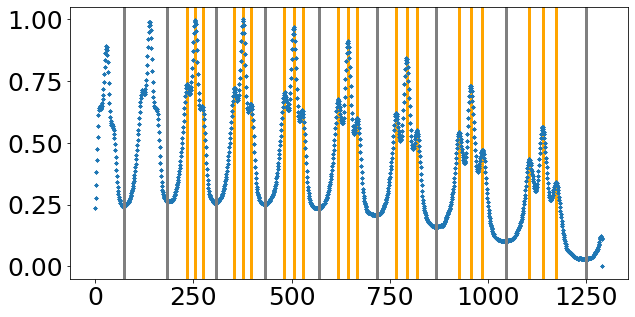

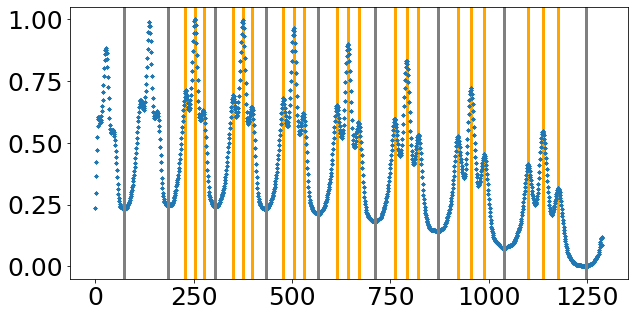

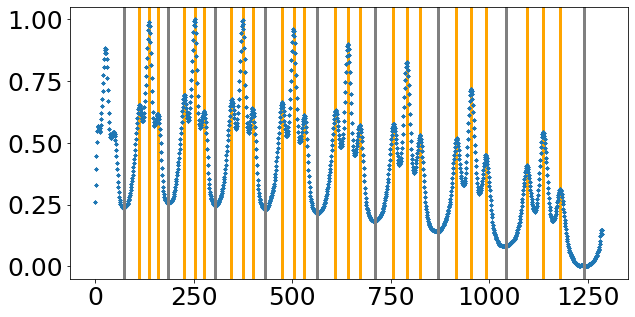

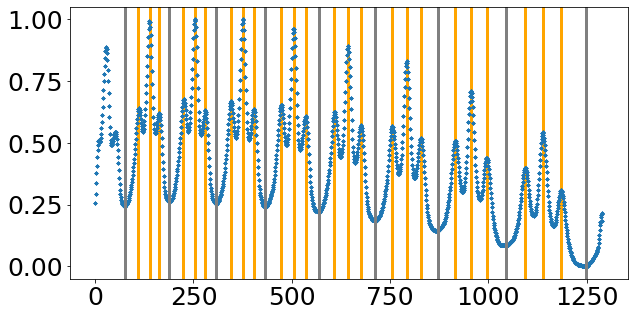

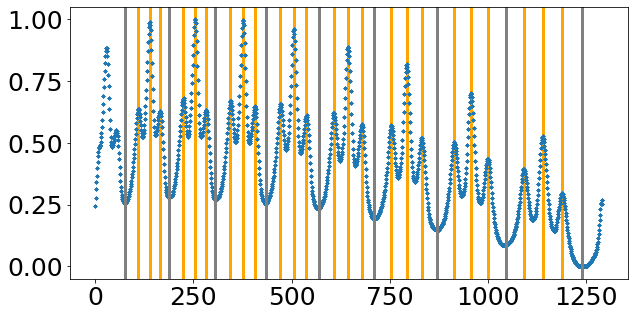

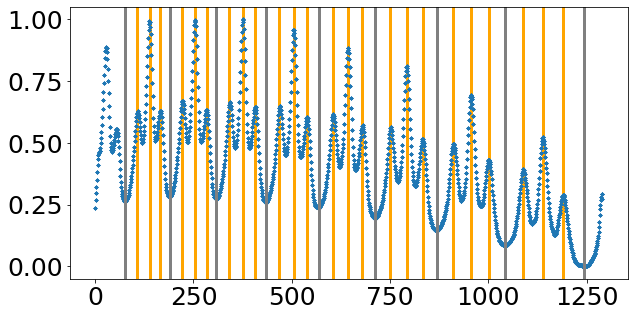

In [27]:
results = [[] for _ in range(6)] #6 verschiedene Stromstärken

for i in range(6):
    if i == 0 or i == 1:
        results[i] = fit_peaks(data1[i][0],data1[i][1], 1,8, 40)
    else:
        results[i] = fit_peaks(data1[i][0],data1[i][1], 0,8, 40)

In [29]:
results[0][0]

[254.56942725474775,
 376.40382373134815,
 505.57598028247054,
 643.6839889186016,
 792.738464861103,
 956.2319037364854,
 1139.2896945873385]

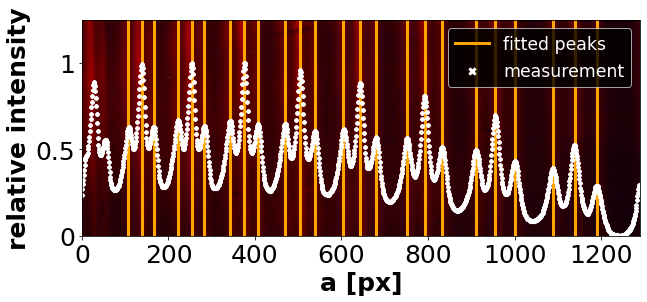

In [30]:
#schöner Plot
img = plt.imread(f"data\\Cd_Zeeman\\06_transverse_nofilter_2.jpg")

_=fit_peaks(data1[5][0],data1[5][1]*400, 0,8, 40, colors=1)
plt.imshow(img,extent=[0, 1290, 0, 500],zorder=-10)
plt.yticks([0,200,400], [0,0.5,1])
plt.xlabel("a [px]")
plt.ylabel("relative intensity")

leg = plt.legend(fontsize="xx-large", frameon=True, markerscale=2, facecolor = "black")
for text in leg.get_texts():
    plt.setp(text, color = 'w')
plt.savefig("plots/Zeeman13A.png")
plt.show()

## determine $\delta a / \Delta a$ and $\delta \lambda$
## + calc $\mu_b$

In [32]:
def pol2(x,p0,p1,p2):
    return p0+p1*x+p2*x*x

def get_daDa(result, plot=False):
    # fit k = f(a)
    pi = np.array(result[0])
    pi_err = np.array(result[1])
    N = len(pi)
    k = np.array(range(N))
    p, cov = curve_fit(pol2,pi,k,sigma = pi_err)
    
    # get k = f(sigma_plus_minus)
    sigma1 = np.array(result[2])
    sigma1_err = np.array(result[3])
    sigma2 = np.array(result[4])
    sigma2_err = np.array(result[5])
    k1 = pol2(sigma1,*p)
    k2 = pol2(sigma2,*p)
    
    # get delk and delk_err
    delk1 = np.abs(k-k1)
    delk2 = np.abs(k-k2)
    delk = np.mean(np.concatenate((delk1,delk2)))
    delk_err = np.std(np.concatenate((delk1,delk2)), ddof=1)
    
    if plot==True:
        plt.figure(figsize=(10,5))
        plt.xlabel("a [px]")
        plt.ylabel("order k")
        plt.yticks([i for i in range(N)])
        plt.grid(alpha=0.3)
        plt.errorbar(pi,k,xerr=pi_err, color = "red", fmt="o", capsize=2, label ="$\pi$-line")
        plt.errorbar(sigma1,k1,xerr=sigma1_err,yerr=np.zeros(N), color = "orange", fmt="o", capsize=2, label ="$\sigma$-lines")
        plt.errorbar(sigma2,k2,xerr=sigma2_err,yerr=np.zeros(N), color = "orange", fmt="o", capsize=2)
        a_line = np.linspace(100,1250,100)
        plt.plot(a_line,pol2(a_line,*p), color = 'gray', zorder = -1, label = "pol2-Fit")
        plt.legend(fontsize="xx-large")
    
    return delk, delk_err

def calc_del_lambda(delk, delk_err):
    n = 1.4567
    d = 4.40*1e-3 #Einheit [m]
    λ = 643.845*1e-9 #Einheit [m]
    λ_err = 0.01*1e-9
    
    Dλ = (λ*λ)/(2*d*np.sqrt(n*n-1))
    del_λ = delk*Dλ 
    del_λ_err = delk_err*Dλ 
    return del_λ, del_λ_err

def calc_mu_b(del_λ, del_λ_err, B, B_err):
    λ = 643.845*1e-9
    #Delta_E = (consts.h*consts.c)/(λ*λ)*del_λ #TODO: why do we need to use this function and not h*c/del_λ
    Delta_E = consts.h*consts.c/λ - consts.h*consts.c/(λ+del_λ) 
    Delta_E_err = del_λ_err*(consts.h*consts.c)/(λ+del_λ)**2
    mu_b = Delta_E/B
    mu_b_err = mu_b * np.sqrt((Delta_E_err/Delta_E)**2 + (B_err/B)**2)
    return mu_b, mu_b_err,Delta_E, Delta_E_err

In [36]:
MUB, MUBerr = [], []
DE, DEerr = [], []
for i,result in enumerate(results):
    delk, delk_err = get_daDa(result)
    del_λ, del_λ_err = calc_del_lambda(delk, delk_err)
    mu_b, mu_b_err, Delta_E, Delta_E_err = calc_mu_b(del_λ, del_λ_err, B1[i], B1_err[i])
    MUB.append(mu_b)
    MUBerr.append(mu_b_err)
    DE.append(Delta_E)
    DEerr.append(Delta_E_err)
    
print(np.mean(np.array(MUB)))
print(np.std(np.array(MUB), ddof=1))

9.114589343877095e-24
1.3981388852601477e-25


MUBerr > std of the mean:
$$mean = \sum_i \frac{x_i}{N}$$
$$mean_{err} = \sqrt{\sum_i \left(\frac{x_{i,err}}{N}\right)^2} = \sqrt{\frac{\sum_i \left(x_{i,err}\right)^2}{N}}$$

In [37]:
#mean_err
print(np.sqrt(np.sum(np.array(MUBerr)**2)/len(MUB)))

4.304496116458788e-25


$$\Rightarrow \mu_B = (9.1 \pm 0.4 ) \cdot 10^{-24} \frac{J}{T}$$

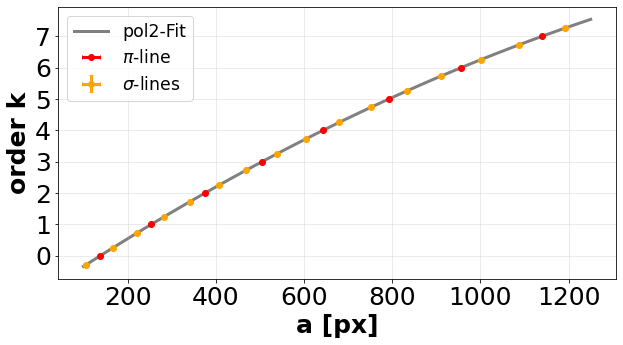

In [38]:
#example plot for I=13
_=get_daDa(results[-1], plot=True)
plt.savefig("plots/SigmaFit13A.png")

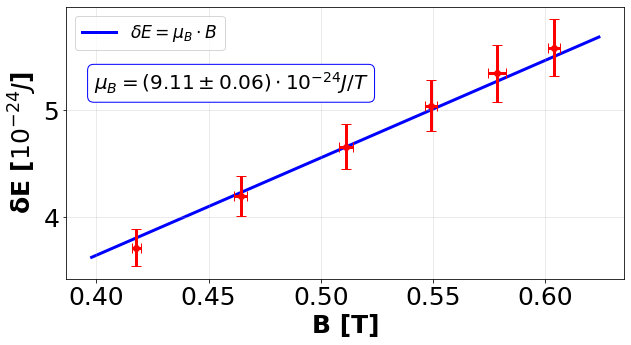

In [39]:
#visualization and fit plot E vs B
plt.figure(figsize=(10,5))
plt.grid(alpha=0.3)
plt.errorbar(B1,np.array(DE)*1e24,xerr=B1_err,yerr=np.array(DEerr)*1e24,fmt="o", color='red', capsize=5)

def EvsB(B,muB):
    return B*muB

p2, cov2 = curve_fit(EvsB,B1,DE,sigma=DEerr)
Bline = np.linspace(B1[0]-0.02,B1[-1]+0.02,100)
plt.plot(Bline, EvsB(Bline,*p2)*1e24, zorder=-1, label = "$\delta E = \mu_B \cdot B$", color = 'blue')
plt.legend(fontsize="xx-large")
plt.xlabel("B [T]")
plt.ylabel("δE [$10^{-24}J$]")

muB2 = np.round(p2[0]*1e24,2)
muB2_err = np.round(np.sqrt(cov2[0][0])*1e24,2)

plt.text(0.46, 5.25, "$\mu_B = $" + f"$\\left({muB2}\pm{muB2_err}\\right)\cdot$"+"$10^{-24}J/T$", size=20,
         ha="center", va="center", zorder = 10,
         bbox=dict(boxstyle="round",
                   ec="blue",
                   fc=(1.,1.,1.),
                   )
         )

plt.savefig("plots/EvsB.png")